===== Regression Models & Price-to-Rent Ratio Analysis =====
 Loading data files...
- Unique blocks found: ['dachang', 'majuqiao', 'yanjiao', 'yizhuang'] (4 types)

===== Training Regression Models =====
 Model 1 (Price per sqm prediction) trained successfully
 Model 2 (Rent per sqm prediction) trained successfully

Model 1 (Price) Details:
  Features: ['Block_majuqiao', 'Block_yanjiao', 'Block_yizhuang', 'area']
  Coefficients: [np.float64(18782.19), np.float64(2404.87), np.float64(48479.19), np.float64(41.46)]
  Intercept: 5537.03

===== Predictions & Price-to-Rent Ratio Calculation =====
 Calculated ratio for 4311 data points

===== Generating Figure B =====


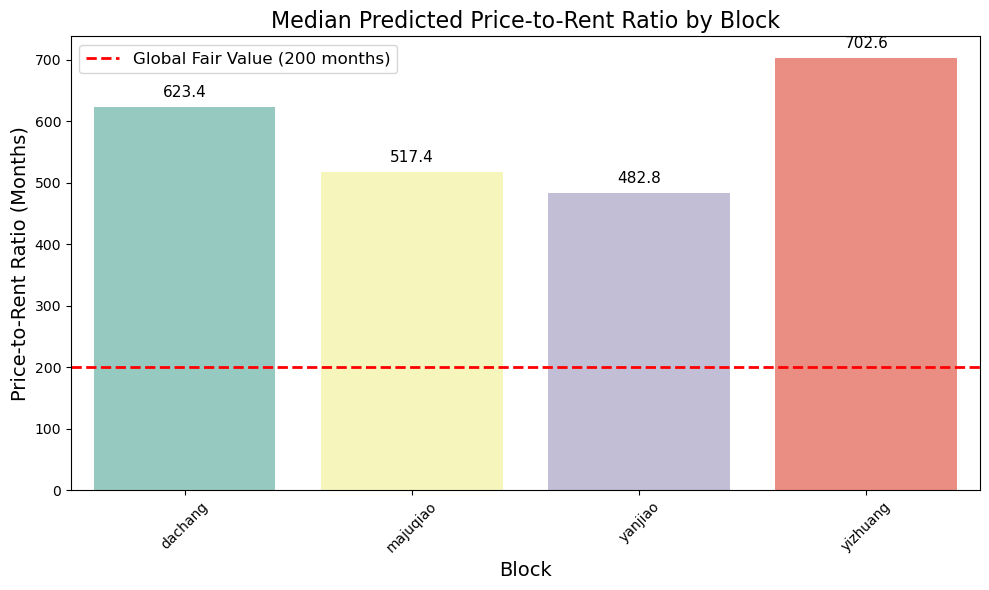

 Figure B saved to 'results/figureB_predicted_ratio.png'

===== Analysis Completed =====
Median Predicted Price-to-Rent Ratio by Block:
   Block  price_rent_ratio
 dachang             623.4
majuqiao             517.4
 yanjiao             482.8
yizhuang             702.6


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os


# 创建结果目录
if not os.path.exists('results'):
    os.makedirs('results')
    print(" 'results' folder created for outputs")

# 数据加载与检查
def load_data():
    try:
        # 尝试读取数据
        print(" Loading data files...")
        housing_df = pd.read_csv('Housing_Price.csv')
        rent_df = pd.read_csv('Rent_Price.csv')
        
        possible_housing_mappings = [
            {'Block': 'Block', '面积': 'area', '单价': 'price_per_sqm'},
        ]
        
        possible_rent_mappings = [
            {'Block': 'Block', '面积': 'area', '每平米月租': 'rent_per_sqm'},
        ]
        
        # 找到可用的列名映射
        housing_cols = None
        for mapping in possible_housing_mappings:
            if all(col in housing_df.columns for col in mapping.keys()):
                housing_cols = mapping
                break
                
        rent_cols = None
        for mapping in possible_rent_mappings:
            if all(col in rent_df.columns for col in mapping.keys()):
                rent_cols = mapping
                break
        
    
        # 重命名列并选择需要的列
        housing_df = housing_df.rename(columns=housing_cols)[['Block', 'area', 'price_per_sqm']]
        rent_df = rent_df.rename(columns=rent_cols)[['Block', 'area', 'rent_per_sqm']]
        
       
        
        # 处理Block列
        housing_df['Block'] = housing_df['Block'].astype(str).str.strip()
        rent_df['Block'] = rent_df['Block'].astype(str).str.strip()
        
        # 处理数值列
        for col in ['area', 'price_per_sqm']:
            housing_df[col] = pd.to_numeric(housing_df[col], errors='coerce')
        
        for col in ['area', 'rent_per_sqm']:
            rent_df[col] = pd.to_numeric(rent_df[col], errors='coerce')
        
        # 显示唯一区域
        unique_blocks = sorted(housing_df['Block'].unique())
        print(f"- Unique blocks found: {unique_blocks} ({len(unique_blocks)} types)")
        
        return housing_df, rent_df
    
    except FileNotFoundError as e:
        print(f"❌ File not found: {str(e)}")
        print("Please ensure 'Housing_Price.csv' and 'Rent_Price.csv' are in the same directory")
        raise
    except Exception as e:
        print(f"❌ Data processing error: {str(e)}")
        raise

# 训练回归模型
def train_regression_models(housing_df, rent_df):
    print("\n===== Training Regression Models =====")
    
    # 再次检查数据
    if len(housing_df) < 5:
        print(f" Warning: Small housing dataset ({len(housing_df)} samples)")
    if len(rent_df) < 5:
        print(f" Warning: Small rent dataset ({len(rent_df)} samples)")
    
    # 定义预处理步骤
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', OneHotEncoder(drop='first', sparse_output=False), ['Block']),
            ('numerical', 'passthrough', ['area'])
        ]
    )
    
    # 模型1: 预测每平米房价
    X1 = housing_df[['Block', 'area']]
    y1 = housing_df['price_per_sqm']
    
    # 检查特征数据
    if X1.shape[0] == 0:
        raise ValueError("No features available for price model training")
    
    model_price = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    model_price.fit(X1, y1)
    print(" Model 1 (Price per sqm prediction) trained successfully")
    
    # 模型2: 预测每平米租金
    X2 = rent_df[['Block', 'area']]
    y2 = rent_df['rent_per_sqm']
    
    # 检查特征数据
    if X2.shape[0] == 0:
        raise ValueError("No features available for rent model training")
    
    model_rent = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    model_rent.fit(X2, y2)
    print(" Model 2 (Rent per sqm prediction) trained successfully")
    
    # 输出模型详情
    print_model_details(model_price, "Model 1 (Price)")
    return model_price, model_rent

def print_model_details(model, model_name):
    """打印模型特征和系数"""
    try:
        ohe = model.named_steps['preprocessor'].transformers_[0][1]
        feature_names = list(ohe.get_feature_names_out(['Block'])) + ['area']
        coefficients = model.named_steps['regressor'].coef_
        intercept = model.named_steps['regressor'].intercept_
        
        print(f"\n{model_name} Details:")
        print(f"  Features: {feature_names}")
        print(f"  Coefficients: {[round(coef, 2) for coef in coefficients]}")
        print(f"  Intercept: {round(intercept, 2)}")
    except Exception as e:
        print(f" Could not retrieve model details: {str(e)}")

# 预测与比率计算
def predict_and_calculate_ratio(housing_df, rent_df, model_price, model_rent):
    print("\n===== Predictions & Price-to-Rent Ratio Calculation =====")
    
    # 生成预测
    housing_df['predicted_price'] = model_price.predict(housing_df[['Block', 'area']])
    rent_df['predicted_rent'] = model_rent.predict(rent_df[['Block', 'area']])
    
    # 按区域合并数据
    combined_data = []
    for block in housing_df['Block'].unique():
        housing_block = housing_df[housing_df['Block'] == block].copy()
        rent_block = rent_df[rent_df['Block'] == block].copy()
        
        min_length = min(len(housing_block), len(rent_block))
        if min_length > 0:
            block_data = pd.DataFrame({
                'Block': block,
                'predicted_price': housing_block['predicted_price'].iloc[:min_length].values,
                'predicted_rent': rent_block['predicted_rent'].iloc[:min_length].values
            })
            combined_data.append(block_data)
    
    # 合并并清洗
    if not combined_data:
        raise ValueError("No matching data between housing and rent datasets")
    
    combined_df = pd.concat(combined_data, ignore_index=True)
    combined_df = combined_df[combined_df['predicted_rent'] > 0]  # 避免除以零
    
    if len(combined_df) == 0:
        raise ValueError("No valid data after filtering for rent > 0")
    
    combined_df['price_rent_ratio'] = (combined_df['predicted_price'] / combined_df['predicted_rent']).round(1)
    print(f" Calculated ratio for {len(combined_df)} data points")
    return combined_df

# 绘制Figure B
def plot_figure_b(combined_df):
    print("\n===== Generating Figure B =====")
    
    median_ratios = combined_df.groupby('Block')['price_rent_ratio'].median().reset_index()
    
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(
        x='Block',
        y='price_rent_ratio',
        data=median_ratios,
        hue='Block',
        palette='Set3',
        legend=False
    )
    
    # 添加参考线
    plt.axhline(
        y=200,
        color='red',
        linestyle='--',
        linewidth=2,
        label='Global Fair Value (200 months)'
    )
    
    # 英文标签
    plt.title('Median Predicted Price-to-Rent Ratio by Block', fontsize=16)
    plt.xlabel('Block', fontsize=14)
    plt.ylabel('Price-to-Rent Ratio (Months)', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    
    # 添加数值标签
    for p in bar_plot.patches:
        bar_plot.annotate(
            f'{p.get_height():.1f}',
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=11
        )
    
    plt.tight_layout()
    plt.savefig('results/figureB_predicted_ratio.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(" Figure B saved to 'results/figureB_predicted_ratio.png'")
    return median_ratios

# 主函数
def main():
    print("===== Regression Models & Price-to-Rent Ratio Analysis =====")
    try:
        # 1. 加载数据（带详细检查）
        housing_data, rent_data = load_data()
        
        # 2. 训练模型
        model_price, model_rent = train_regression_models(housing_data, rent_data)
        
        # 3. 预测并计算比率
        combined_df = predict_and_calculate_ratio(housing_data, rent_data, model_price, model_rent)
        
        # 4. 生成Figure B
        median_ratios = plot_figure_b(combined_df)
        
        # 5. 输出结果
        print("\n===== Analysis Completed =====")
        print("Median Predicted Price-to-Rent Ratio by Block:")
        print(median_ratios.to_string(index=False))
    
    except Exception as e:
        print(f"\n Analysis failed: {str(e)}")
        print("Please check your data files and try again")

if __name__ == "__main__":
    main()
    